<a href="https://colab.research.google.com/github/sefamertgungor/tumorDetection/blob/main/t1ce_brain_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Zip icerisinde bulunan verileri cikarmak icin kullanilabilir
from zipfile import ZipFile

# Verilerin bulundugu Zip konumu
file_name = "/content/drive/MyDrive/Proje/deneme.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras
!pip install simpleitk

# Verilerin oldugu klasor yolu
yol = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

import os
os.listdir(yol)

     |████████████████████████████████| 47.4MB 63kB/s 


['BraTS20_Training_045',
 'BraTS20_Training_087',
 'BraTS20_Training_075',
 'BraTS20_Training_014',
 'BraTS20_Training_023',
 'BraTS20_Training_090',
 'BraTS20_Training_079',
 'BraTS20_Training_038',
 'BraTS20_Training_013',
 'BraTS20_Training_010',
 'BraTS20_Training_019',
 'BraTS20_Training_081',
 'BraTS20_Training_007',
 'BraTS20_Training_072',
 'BraTS20_Training_035',
 'BraTS20_Training_003',
 'BraTS20_Training_068',
 'BraTS20_Training_012',
 'BraTS20_Training_078',
 'BraTS20_Training_018',
 'BraTS20_Training_016',
 'BraTS20_Training_034',
 'BraTS20_Training_086',
 'BraTS20_Training_088',
 'BraTS20_Training_046',
 'BraTS20_Training_073',
 'BraTS20_Training_044',
 'BraTS20_Training_085',
 'BraTS20_Training_004',
 'BraTS20_Training_042',
 'BraTS20_Training_027',
 'BraTS20_Training_006',
 'BraTS20_Training_011',
 'BraTS20_Training_093',
 'BraTS20_Training_051',
 'BraTS20_Training_071',
 'BraTS20_Training_056',
 'BraTS20_Training_082',
 'BraTS20_Training_040',
 'BraTS20_Training_074',


In [4]:
len(os.listdir(yol))

94

In [5]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!


def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

In [6]:
seg_geniş   = seg_array(yol,'**/*seg.nii',4)
seg_ödemsiz = seg_array(yol,'**/*seg.nii',3)
t1ce = train_array(yol,'**/*t1ce.nii')

In [7]:
seg_geniş.shape, seg_ödemsiz.shape, t1ce.shape

((6580, 1, 240, 240), (6580, 1, 240, 240), (6580, 1, 240, 240))

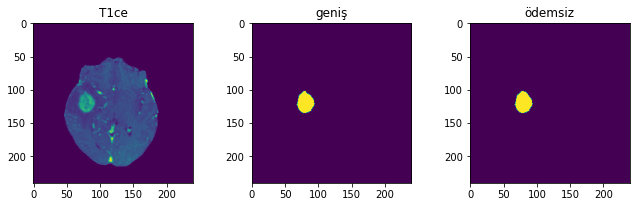

In [9]:
# T1ce goruntusu ve aynı goruntunun segmente hali
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[425,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_geniş[425,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_ödemsiz[425,0,:,:])

In [10]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

def tumortoarray(tumor,segmentasyon):
    
    liste_boş= []

    for i in range(len(segmentasyon)):
        img = tümör_kırpma(tumor[i],segmentasyon[i])
        if len(img.shape) > 2:
            liste_boş.append(img)
            #print(f'{i}')

    return np.array(liste_boş)

ödemsiz = tumortoarray(seg_ödemsiz,seg_ödemsiz)
geniş = tumortoarray(seg_geniş,seg_ödemsiz)
t1ce_kırp = tumortoarray(t1ce,seg_ödemsiz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# Kirpilmis goruntunun boyutlari
t1ce_kırp.shape, ödemsiz.shape, geniş.shape

((2905, 1, 64, 64), (2905, 1, 64, 64), (2905, 1, 64, 64))

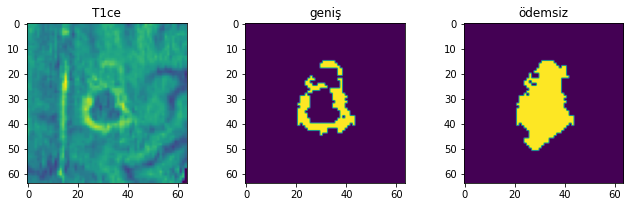

In [15]:
# Kirpilmis T1ce goruntusu ve radyoloji uzmani tarafindan segmente edilmis hali
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[405,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş[405,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz[405,0,:,:])

In [17]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')

def acc(y_true, y_pred):
    y_pred_f = K.flatten(K.round(y_pred))
    y_true_f = K.flatten(y_true)
    num = K.sum(y_true_f * y_pred_f)
    den = K.sum(y_true_f) + K.sum(y_pred_f) - num
    return num / den


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = ['binary_crossentropy'], metrics = [acc])

    return model

In [18]:
model_ödemsiz = unet_model_7()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
history = model_ödemsiz.fit(t1ce_kırp, ödemsiz,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 30,
                       shuffle=True,
                       verbose=1)

Epoch 1/30
233/233 [==============================] - 63s 50ms/step - loss: 0.4223 - acc: 0.5291 - val_loss: 0.3324 - val_acc: 0.3013
Epoch 2/30
233/233 [==============================] - 9s 39ms/step - loss: 0.1445 - acc: 0.8063 - val_loss: 0.1585 - val_acc: 0.6633
Epoch 3/30
233/233 [==============================] - 9s 39ms/step - loss: 0.1112 - acc: 0.8277 - val_loss: 0.1039 - val_acc: 0.7792
Epoch 4/30
233/233 [==============================] - 9s 40ms/step - loss: 0.0819 - acc: 0.8610 - val_loss: 0.1027 - val_acc: 0.7839
Epoch 5/30
233/233 [==============================] - 9s 40ms/step - loss: 0.0698 - acc: 0.8735 - val_loss: 0.1191 - val_acc: 0.7502
Epoch 6/30
233/233 [==============================] - 9s 41ms/step - loss: 0.0594 - acc: 0.8853 - val_loss: 0.1024 - val_acc: 0.7896
Epoch 7/30
233/233 [==============================] - 10s 41ms/step - loss: 0.0525 - acc: 0.8927 - val_loss: 0.1323 - val_acc: 0.7306
Epoch 8/30
233/233 [==============================] - 10s 42ms/step

In [20]:
model_geniş = unet_model_7()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
history = model_geniş.fit(t1ce_kırp, geniş,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 30,
                       shuffle=True,
                       verbose=1)

Epoch 1/30
233/233 [==============================] - 14s 45ms/step - loss: 0.4733 - acc: 0.4429 - val_loss: 0.2366 - val_acc: 0.3507
Epoch 2/30
233/233 [==============================] - 10s 41ms/step - loss: 0.2350 - acc: 0.6966 - val_loss: 0.1491 - val_acc: 0.6294
Epoch 3/30
233/233 [==============================] - 10s 42ms/step - loss: 0.1646 - acc: 0.7397 - val_loss: 0.1450 - val_acc: 0.5811
Epoch 4/30
233/233 [==============================] - 10s 42ms/step - loss: 0.1327 - acc: 0.7427 - val_loss: 0.1409 - val_acc: 0.6883
Epoch 5/30
233/233 [==============================] - 10s 41ms/step - loss: 0.0955 - acc: 0.7796 - val_loss: 0.1292 - val_acc: 0.6800
Epoch 6/30
233/233 [==============================] - 10s 41ms/step - loss: 0.0778 - acc: 0.7949 - val_loss: 0.1361 - val_acc: 0.7026
Epoch 7/30
233/233 [==============================] - 10s 41ms/step - loss: 0.0649 - acc: 0.8081 - val_loss: 0.1147 - val_acc: 0.6760
Epoch 8/30
233/233 [==============================] - 10s 41ms

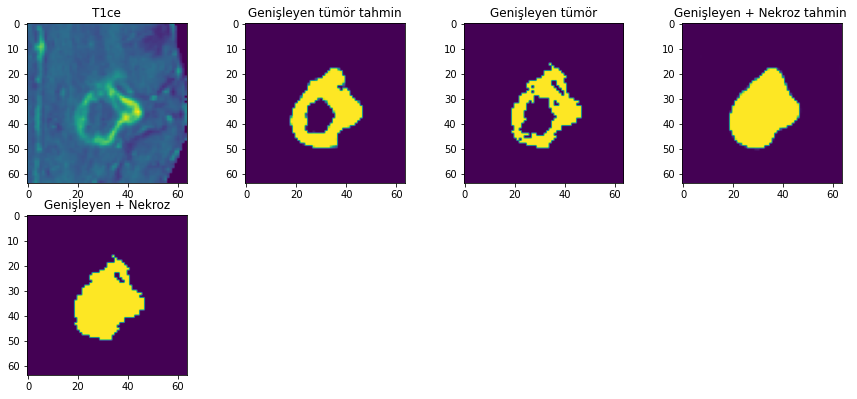

In [ ]:
# Ikıncı kırpma algoritmasina gore kirpilmis goruntuler icin tahminler
x = 400

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[x,0,:,:])


pred_geniş = model_geniş.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Genişleyen tümör')
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz[x,0,:,:])



In [23]:
# Zip icerisinde bulunan verileri cikarmak icin kullanilabilir
from zipfile import ZipFile

# Test verilerinin bulundugu konum
file_name = "/content/drive/MyDrive/Proje/Test2.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [39]:
def kirpma(goruntu, tumor):

  #print("------>>>>>>{}".format(tumor.shape))

  liste = []

  ysol = 0
  ysag = 64

  xsol = 0
  xsag =64

  adim = 30

  tut = 0
  tutx = 0
  tutSize = 0

  while True:

    ysol = 0
    ysag = 64

    while True:
      if ysag >240:
        break
      t1CE = tumor.copy()
      kirpilan = t1CE[goruntu,0,ysol:ysag,xsol:xsag]
      kirpilan[kirpilan < 3.5] = 1
      """print("ysol --> {}, ysag --> {}".format(ysol, ysag))
      print("xsol --> {}, xsag --> {}".format(xsol, xsag))
      print("Goruntu yogunlugu --> {}".format(kirpilan[kirpilan>3].size))
      print("*\n")"""
      ysol += adim
      ysag += adim

      if kirpilan[kirpilan>3].size > tutSize:
        tutSize = kirpilan[kirpilan>3].size
        tut = ysag
        tutx = xsag

    xsol += adim
    xsag += adim 
    if xsag >240:
        break

  tut -=30

  img_x =  np.zeros((64,64), np.float32)
  boyut2 = tumor[goruntu][0]
  img_x[:,:] = boyut2[tut-64:tut,tutx-64:tutx]
  liste.append(img_x)

  return np.array(liste)

def tumortoarray(tumor):

    liste_boş= []

    for i in range(len(tumor)):

        img = kirpma(i,tumor)
        #print("------>{}.Adim".format(i))
        if len(img.shape) > 2:
            liste_boş.append(img)
            #print(f'{i}')

    return np.array(liste_boş)

In [40]:
yol3 = '/content/Test2/MICCAI_BraTS2020_TrainingData/'

os.listdir(yol3)

['BraTS20_Training_246']

In [41]:
t1ceee = train_array(yol3,'**//*t1ce.nii')
t1ceee.shape

(70, 1, 240, 240)

In [42]:
# Goruntu yogunluk oranina gore kirpildi
kirpilmis = tumortoarray(t1ceee)

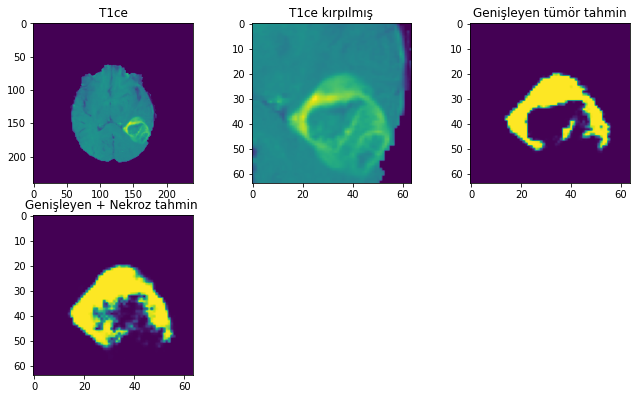

In [43]:
# Ikıncı kırpma algoritmasina gore kirpilmis goruntuler icin tahminler
x = 15

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ceee[x,0,:,:])


plt.subplot(3,4,2)
plt.title('T1ce kırpılmış')
plt.imshow(kirpilmis[x,0,:,:])

pred_geniş = model_geniş.predict(kirpilmis[x:x+1,:,:,:])
plt.subplot(3,4,3)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )


pred_ödemsiz = model_ödemsiz.predict(kirpilmis[x:x+1,:,:,:])
plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )